### Predict Loan Defaulters Part 2_Pre-Processing
We will be processing this notebook using the insight we gained from the first notebook (link below). <br>

[Predict Loan Defaulters: Part 1 - EDA](https://nbviewer.jupyter.org/gist/marcelkore/0115941837b398617e535024b4c8ba56) 

I will be running the pipelines one by one for the purpose of going through the different steps invoveld in processing this dataset

<h3>Notebook Setup</h3>

<ol>
  <li>Create Transformers to handle diffrents processing needs of our dataset </li>
  <li>Apply Transformation to train and test data</li>
</ol> 


[Github Link to orginial notebooks and helper files](https://github.com/marcelkore/Predict_Good_Loans)

### Steps in the process
1. [Reading the DataSet](#reading_the_data)
2. [Encode Target Feature](#encode_target)
3. [Drop Data Leakage Features](#drop_data_leak)
3. [Drop Duplicates](#drop_duplicates)  
3. [Drop Single Unique Features](#single_unique)  
3. [Handle Missing - Drop Using Threshold](#missing_features)  
3. [Impute Categoricals](#impute_categorical)  
3. [Impute Numerical](#impute_numerical)  
3. [Feature Extraction](#feature_extraction)  
3. [Feature Engineering](#feature_engineer)
3. [Feature Selection](#feature_selector)
3. [Export DataSet](#export_dataset)

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np

# category encoding
import category_encoders as ce

#helper functions
import helper_functions as helpers
import modeling_helper_functions as mhf
import parameter_tuning_helper as pt
from mlxtend.evaluate import scoring

#skearn libraries
from sklearn.pipeline import make_pipeline, Pipeline
#from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.impute import SimpleImputer

from missingpy import MissForest

'''
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_curve, precision_recall_curve)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from mlxtend.evaluate import feature_importance_permutation

'''

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import lightgbm as lgb
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel


# feature selection
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xverse.transformer import WOE
import boruta_py as bpy

import yagmail
from missingpy import MissForest

import itertools
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
from datetime import date

from IPython.core.interactiveshell import InteractiveShell

# Viz Libraries
import seaborn as sns
import psutil
import matplotlib.style as style
import matplotlib.pyplot as plt
%matplotlib inline
style.use('fivethirtyeight')

import psutil

import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import modeling_helper_functions as mhf
import parameter_tuning_helper as pt
from skew_autotransform import skew_autotransform

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be r

In [2]:
print('Total number of cpus detected: {}.'.format(psutil.cpu_count()))
print('Total size of system memory: {:.5f} gb.'.format(psutil.virtual_memory().total / 1e9))

Total number of cpus detected: 16.
Total size of system memory: 68.40692 gb.


In [3]:
%%script False
!pip install category_encoders
!pip install shap
!pip install xverse
!pip install yagmail
!pip install missingpy
!pip install mlxtend
!pip install eli5
!pip install scikit_plot
!pip install yellowbrick
!pip install xgboost
!pip install catboost
!pip install hyperopt
!pip install missingpy
!pip install lightgbm
!pip install mlens

Couldn't find program: 'False'


In [4]:
# track how long notebook took to run
notebook_start_time = datetime.now()

In [5]:
#!pip install -r requirements.txt
#! pipreqs

In [6]:
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
# scientific notation
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [7]:
# not advised but for the ease of running multiple iterations of this notebook, 
# i set a couple of global variables for use in the subsequent functions
CPU_COUNT = -1
CROSS_VAL_COUNT = 10
SCORING_METRIC = 'f1_weighted'

We noticed a large class imbalance in the dataset from 2007 to 2018 in the Exploratory Phase. The strategy I used for the <br>
balanced dataset below is to use all the negative samples from 2007 to 2016 together with all the negative samples from the previous <br>
years resulting in a more or less balanced dataset (see catplots below). 

In [8]:
# load the balanced dataset
df = pd.read_csv('lc_data_balanced.csv')

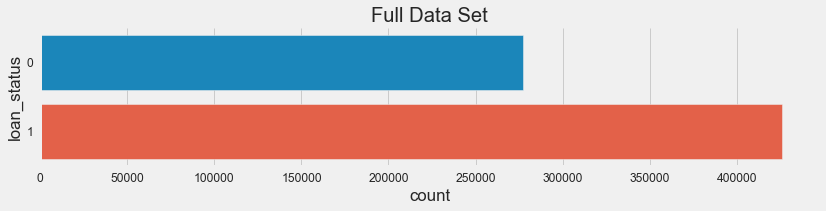

In [9]:
# review our target feature distribution
sns.catplot(y="loan_status", kind="count", data=df, height=2.6, aspect=4.5, orient='h')
plt.title('Full Data Set')
plt.show();

## **Convert DataTypes**
<a id="encode_target"></a>
<p> For memory management, this first transformer converts 'object' datatypes to the less memory demanding 'category' data types. <br>
    We also convert any 'float64' data types to 'float32' <br>

In [10]:
class ConvertDataTypes(TransformerMixin,BaseEstimator):
    """
    This transformer receives a dataframe and performs the following conversion:
    
    Any 'object' datatypes present are converted to 'category' datatype
    Any 'float64' datatypes present are covnerted to 'float32' datatype
    
    Args: Pass a dataframe
    
    Returns: 
    A dataframe with the data types converted
    
    """
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df): # pass the dataframe
        '''
        This transformer calls the convert_data_type function from the helpers_functions file. 
        '''
        df = helpers.reduce_mem_usage(df)
        
        df = helpers.convert_data_type(df)
        
        return df

In [11]:
# create transformer 
data_type_encoder = ConvertDataTypes()

#fit transform dataset
df = data_type_encoder.fit_transform(df)

# confirm
print("Train Set Size: {}".format(df.shape))

Memory usage of dataframe is 815.54 MB
Memory usage after optimization is: 247.74 MB
Decreased by 69.6%
Train Set Size: (703252, 152)


### <b> Split into Test, Train, Split<b>

In [12]:
# split the data into two - a train set with 70% and 30% for validation and hold-out test
train_set, set_b = train_test_split(df,test_size=0.30, random_state=2019, stratify=df['loan_status'])

In [13]:
# we perform a second split here for test set and hold out test set
test_set, hold_out_test = train_test_split(set_b,test_size=0.30, random_state=2019, stratify=set_b['loan_status'])

In [14]:
print("Train Set Shape {}, Test Set Shape {}".format(train_set.shape,test_set.shape))
print("Hold Out Test Set Shape: {}".format(hold_out_test.shape))

Train Set Shape (492276, 152), Test Set Shape (147683, 152)
Hold Out Test Set Shape: (63293, 152)


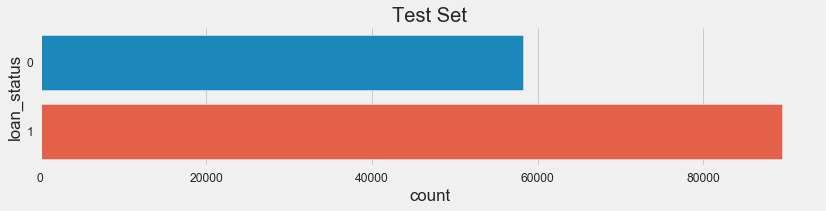

In [15]:
# review new distribution of our target feature
sns.catplot(y="loan_status", kind="count", data=test_set, height=2.6, aspect=4.5, orient='h')
plt.title('Test Set')
plt.show();

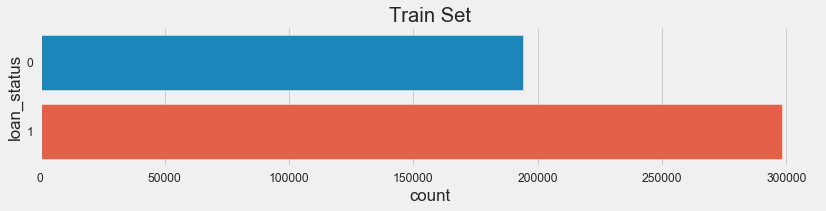

In [16]:
# review new distribution of our target feature
sns.catplot(y="loan_status", kind="count", data=train_set, height=2.6, aspect=4.5, orient='h')
plt.title('Train Set')
plt.show();

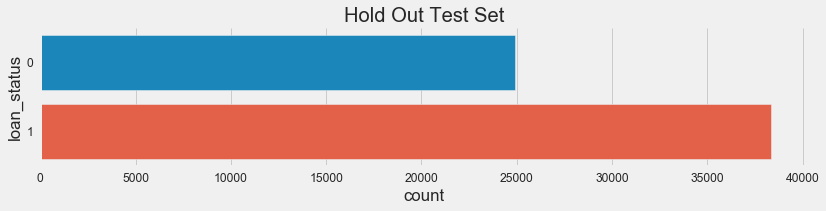

In [17]:
# review new distribution of our target feature
sns.catplot(y="loan_status", kind="count", data=hold_out_test, height=2.6, aspect=4.5, orient='h')
plt.title('Hold Out Test Set')
plt.show();

<h2><b> Pre-Process Transformers <b></h2>
<a id="transformers"></a>
We will start our feature selection process during the cleaning phase. With the large number of features available in this dataset,<br> we will first target low hanging fruit i.e., features with a large % of Missing Values, low variance features as candidates for dropping. <p> 
    
<p> We will also drop features as we proceed based on domain/common knowledge i.e., index columns,customer name columns <br>and data collected after a loan applicant has been approved i.e.Target Leak candidates </p>

<h2><b> Drop Features <b></h2>
<a id="drop_features"></a>

We will create a `transformer` that will handle dropping of the following features in our dataset

* Irrelevant features that will not inform our final model i.e, indexes
* Data Leakage features (see below)
* Other features that we determine are not required

<p> Data Leakage has to do with using features collected after our event of interest ..in this case, defaulting on a loan.<br>
    To put it in another way, these features will not be available to you prior to making the decision whether you should give an <br>
    individual a loan or not. The business has to make a decision prior with all the features that make it to our final model
    
More details on the link below.
</p>  
<p> <a href="https://machinelearningmastery.com/data-leakage-machine-learning/">Data Leakage in Machine Learning</a></p>


In [18]:
class DropFeatures(TransformerMixin,BaseEstimator):
    """
    This transformer drops features passed in a list and returns
    a dataframe with the features dropped.
    
    Args:
    A list of feature names to be dropped and the dataframe object
    Returns:
    A dataframe with the features provided dropped. 
    """
       
    def __init__(self,drop_candidates): # pass list of features to be dropped
        self.to_drop = drop_candidates
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
               
        drop_features = []
        for value in self.to_drop:
            if value in df.columns:
                drop_features.append(value)
                
        # Drop the features selected above passed in drop_candidates
        return df.drop(labels=drop_features,axis=1) # return dataframe with dropped features

In [19]:
# below is a list of features i have determined to either be target leak features or features
# that will not inform our model
leakage_not_required_features=['recoveries','collection_recovery_fee','last_pymnt_amnt','total_rec_prncp','title',\
                    'total_rec_int','total_rec_late_fee','last_pymnt_d','total_pymnt','funded_amnt',\
                      'total_pymnt_inv','last_credit_pull_d','issue_d','funded_amnt_inv','debt_settlement_flag',\
                'id','member_id','addr_state','zip_code','emp_title','payment_plan_start_date',
                'last_fico_range_low','last_fico_range_high','url','issue_date', 'disbursement_method',\
                'desc', 'next_pymnt_d', 'orig_projected_additional_accrued_interest','next_pymnt_d']


# we are not going to know payment plan features before providing a loan decision, hence we drop them
payment_plan_features = [x for x in train_set.columns[train_set.columns.str.contains('payment')]]

# we are not going to know settlement features before providing a loan decision, hence we drop them
settlement_features = [x for x in train_set.columns[train_set.columns.str.contains('settlement')]]

# hardship features are included if an individual starts facing difficulties during the 
# life of the loan. definetly information we will not have. hence we drop them
hardship_features = [x for x in train_set.columns[train_set.columns.str.contains('hardship')]]

# we combine the list of all the features identified above into one list
features_to_drop = leakage_not_required_features + payment_plan_features + settlement_features + hardship_features

In [20]:
print("Number of features to be dropped including target leakeage features: {}".format(len(features_to_drop)))
print("")

# drop_features
print("Number of Payment plan features to be dropped: {}".format(len(payment_plan_features)))
print("")
print("Number of Settlement features to be dropped: {}".format(len(payment_plan_features)))
print("")
print("Number of Hardship features to be dropped: {}".format(len(hardship_features)))

Number of features to be dropped including target leakeage features: 51

Number of Payment plan features to be dropped: 2

Number of Settlement features to be dropped: 2

Number of Hardship features to be dropped: 12


In [21]:
#create transformer
drop_features_transformer = DropFeatures(features_to_drop)

# fit transform training set
train_set = drop_features_transformer.fit_transform(train_set)

#fit transform dataset
test_set = drop_features_transformer.fit_transform(test_set)
hold_out_test = drop_features_transformer.fit_transform(hold_out_test)

# confirm
print("Train Set Size: {}, Test Set Size: {}".format(train_set.shape, test_set.shape))

Train Set Size: (492276, 105), Test Set Size: (147683, 105)


<h2><b> Drop Joint Applications <b></h2>
<a id="drop_joint_applications"></a>

In [22]:
# check application type unique counts
train_set.application_type.value_counts(normalize=True)

Individual   0.96
Joint App    0.04
Name: application_type, dtype: float64

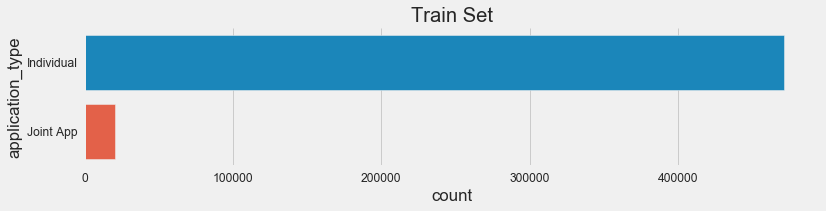

In [23]:
# review new distribution of our application types
sns.catplot(y="application_type", kind="count", data=train_set, height=2.6, aspect=4.5, orient='h')
plt.title('Train Set')
plt.show();

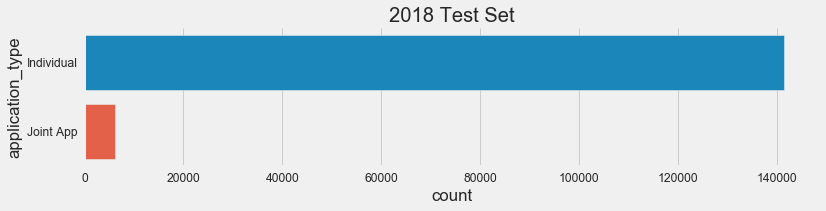

In [24]:
# review new distribution of our application types
sns.catplot(y="application_type", kind="count", data=test_set, height=2.6, aspect=4.5, orient='h')
plt.title('2018 Test Set')
plt.show();

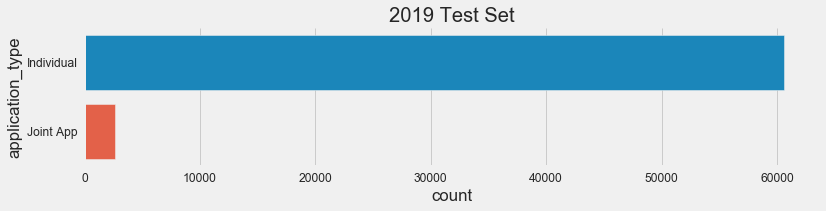

In [25]:
# review new distribution of our application types
sns.catplot(y="application_type", kind="count", data=hold_out_test, height=2.6, aspect=4.5, orient='h')
plt.title('2019 Test Set')
plt.show();

<p> The output above shows that we have more examples of individual vs joint applications. We want to avoid imbalanced <br> features and more importantly, we can drop 17+ features related to joint applicants that will be otherwise missing. <br>
Let's drop those observations and any joint application features available in the dataset i.e., joint & secondary applicant
references <br>

In [26]:
class DropJointApplications(TransformerMixin,BaseEstimator):
    """
    This transformer drops feature names that match our strings of interest. 
    In our case, any references to sec & joint
    
    Args: 
    ---------------------------------------------
    A datframe with our features
    
    Returns:
    ---------------------------------------------
    A dataframe without any features with references
    to sec, join, hardship and settlement   
    
    """
       
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        # we can now assume all references to a secondary applicant start with sec
        self.secondary_applicant_drop = [x for x in df.columns[df.columns.str.match('sec')]]
        # retrieve columns that contain the word joint which is similar to the
        self.secondary_applicant_drop_joint = [x for x in df.columns[df.columns.str.contains('joint')]]
   
        # Lets drop those features
        df.drop(labels=self.secondary_applicant_drop + self.secondary_applicant_drop_joint,inplace=True,axis=1)
        return df

In [27]:
#create transformer
drop_joint_applications_transformer = DropJointApplications()

# fit transform training set
train_set = drop_joint_applications_transformer.fit_transform(train_set)

#fit transform dataset
test_set = drop_joint_applications_transformer.fit_transform(test_set)
hold_out_test = drop_joint_applications_transformer.fit_transform(hold_out_test)

# confirm
print("Train Set Size: {}, Test Set Size: {}".format(train_set.shape, test_set.shape))

Train Set Size: (492276, 89), Test Set Size: (147683, 89)


<h2><b> Drop Duplicates <b></h2>
<a id="drop_duplicates"></a>

Duplicate values decrease the performance of some models. We will drop duplicate observations in the dataset

In [28]:
class DropDuplicates(TransformerMixin,BaseEstimator):
    """
    This transformer drops duplicate observations in the dataset
    
    Args:
    a dataframe
    
    Returns:
    a datframe with all duplicates observations dropped
    
    """
       
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        # use the pandas function drop duplicates
        df.drop_duplicates(inplace=True)
        return df

In [29]:
#create transformer
drop_duplicates = DropDuplicates()

# fit transform training set
train_set = drop_duplicates.fit_transform(train_set)

#fit transform dataset
test_set = drop_duplicates.fit_transform(test_set)
hold_out_test = drop_duplicates.fit_transform(hold_out_test)

# confirm
print("Train Set Size: {}, Test Set Size: {}".format(train_set.shape, test_set.shape))

Train Set Size: (492276, 89), Test Set Size: (147683, 89)


<h2><b> Low Variance Features <b></h2>
<a id="single_unique"></a>

<p> Single unique values do not provide enough variance to benefit a ML algorithm. <p> 
<p> A feature with all zero would not be able to discriminate instances from the different loan status classes <p>

In [30]:
class LowVarianceTransformer(TransformerMixin,BaseEstimator):
    """
    This transformer drops features with single unique values
    
    Args:
    a dataframe
    
    Returns:
    a dataframe with all features with single unique values
    dropped
    
    """
       
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        """
        Call function that drops single unique values given a 
        dataframe
        """
        
        df = helpers.drop_low_variance_features(df)
        
        return df

In [31]:
#create transformer
drop_low_variance= LowVarianceTransformer()

# fit transform training set
train_set = drop_low_variance.fit_transform(train_set)

#fit transform dataset
test_set = drop_low_variance.fit_transform(test_set)
hold_out_test = drop_low_variance.fit_transform(hold_out_test)

# confirm
print("Train Set Size: {}, Test Set Size: {}".format(train_set.shape, test_set.shape))

The number of features with single unique values is 2
The number of features with single unique values is 2
The number of features with single unique values is 2
Train Set Size: (492276, 87), Test Set Size: (147683, 87)


In [32]:
# check number of features with missing values in the dataset
helpers.missing_values_table(train_set).head(15)

Your selected dataframe has 87 columns.
There are 61 columns that have missing values.


,Missing Values,% of Total Values
mths_since_last_record,399265,81.10
mths_since_recent_bc_dlq,371973,75.60
mths_since_last_major_derog,353495,71.80
mths_since_recent_revol_delinq,322262,65.50
mths_since_last_delinq,241447,49.00
il_util,157262,31.90
mths_since_rcnt_il,115102,23.40
all_util,104715,21.30
total_cu_tl,104673,21.30
inq_last_12m,104673,21.30


<h2><b> Impute Numerical Features <b></h2>
<a id="impute_numerical"></a>

We create a `transformer` that will handle imputing numerical features. We will impute specific 'count' features that <br>
would be penalized  if replaced with a mean or median. These features are relevant in the sense that having an occurence <br>
of them is significant i.e., number of charged_off_accounts. The difference between having 1 or more charged_off_accounts <br>
and having none (0) means a lot as the latter signifies a discplined clean record  while the former has shown that they <br>
are capable of 'defaulting' on an account. Imputing such features with a mean or a median does not  make any sense as they <br>
will 'penalize' the observation uncessarily 

In [33]:
class ReplaceWithValue(TransformerMixin,BaseEstimator):
    """
    This transformer imputes missing  categoricals by replacing them 
    with the median value.
    
    Args:
    features set: A dataframe
    
    Returns: 
    A dataframe with numerical features imputed
    """
    def __init__(self, replace_with_value = None):
        self.replace_with_value = replace_with_value
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        """
        Call function that imputes missing values in features
        passed with a specific value. In this instance the default
        replacement value is 0 
        """
        
        features_to_impute = []
        
        for value in self.replace_with_value:
            if value in df.columns:
                features_to_impute.append(value)        
        
        
        return helpers.impute_numerical_features(df,features_to_impute=features_to_impute)
    

Below code selects features that are 'counts' of observations i.e., months since last derogatory account, number of open accounts etc. <br>

We will replace all missing instances with zero instead of a median or mean value. 

In [34]:
mths_since = [x for x in train_set.columns[train_set.columns.str.match('mths_since')]]
inquiries_since = [x for x in train_set.columns[train_set.columns.str.match('inq_')]]
mo_since = [x for x in train_set.columns[train_set.columns.str.match('mo_sin')]]
number_of_counts = [x for x in train_set.columns[train_set.columns.str.match('num_')]]
number_of_open_a = [x for x in train_set.columns[train_set.columns.str.match('open_')]]
number_of_open_b = [x for x in train_set.columns[train_set.columns.str.match('acc_now')]]
number_of_open_c = [x for x in train_set.columns[train_set.columns.str.match('chargeoff_within')]]
number_of_open_d = [x for x in train_set.columns[train_set.columns.str.match('inq_last')]]
number_of_open_e = [x for x in train_set.columns[train_set.columns.str.match('mort_')]]

# ['num_tl_120dpd_2m',  'acc_now_delinq', 'num_tl_30dpd']
                                                                             
replace_with_zero = number_of_open_a + number_of_open_b +\
                    number_of_open_c + number_of_open_d +\
                    number_of_open_d + number_of_open_e +\
                    mths_since + number_of_counts +\
                    mo_since + inquiries_since

In [35]:
replace_with_value = ReplaceWithValue(replace_with_zero)

# fit transform train set
train_set = replace_with_value.fit_transform(train_set)

#fit transform dataset
test_set = replace_with_value.fit_transform(test_set)
hold_out_test = replace_with_value.fit_transform(hold_out_test)

# confirm
print("Train Set Size: {}, Test Set Size: {}".format(train_set.shape, test_set.shape))

43 features have been imputed with 0 value
43 features have been imputed with 0 value
43 features have been imputed with 0 value
Train Set Size: (492276, 87), Test Set Size: (147683, 87)


<h2><b> Feature Extraction <b></h2>
<a id="feature_extraction"></a>

`Feature extraction`, not to be confused by `Feature Engineering` or feature selection in my opinion deals with extracting features from the <br>
existing features. Feature engineering aims to create new features and dimension reduction techniques come up with completly new features that are <br>
representative of the orginial data . <br>
<br>
We will create the `transformer` below to perform feature extraction on the dataset

In [36]:
class FeatureExtraction(TransformerMixin,BaseEstimator):
    
    """
    This transformer takes as input a dataframe and a list of features. It then
    strips the strings values and leaves only the numerical values resulting in a numeric feature. 
    
    As a secondary step, it also maintains the category dtype for categorical features. 
    
    Args: a dataframe, list of  features to be extracted
    
    Returns: a dataframe with features extracted
     
    """
    
    def __init__(self,features_to_extract, convert_to_category): # pass list of features with potential numerical values
        self.features = features_to_extract
        self.convert_cats = convert_to_category
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        # calls a function for the helpers file that extract numerical features from a list passed
        return helpers.extract_numerical_features(df,
                                                  feature_names_to_extract=self.features,
                                                  convert_to_categorical=self.convert_cats)

In [37]:
# variable for feature extractor - pass features you want to extract numerical
features_to_extract = ['term','emp_length','earliest_cr_line']
convert_to_categorical_dtype = ['term','emp_length']

In [38]:
#create transformer
feature_extractor = FeatureExtraction(features_to_extract,convert_to_category = convert_to_categorical_dtype)

# fit transform training set
train_set = feature_extractor.fit_transform(train_set)

#fit transform dataset
test_set = feature_extractor.fit_transform(test_set)
hold_out_test = feature_extractor.fit_transform(hold_out_test)

# confirm
print("Train Set Size: {}, Test Set Size: {}".format(train_set.shape, test_set.shape))

Train Set Size: (492276, 87), Test Set Size: (147683, 87)


<h2><b> Handle Missing Values - Drop Using Threshold <b></h2>
<a id="missing_features"></a>

We will create a `transformer` that will handle dropping of features with missing values and scenarios where imputation should work. This transformer uses a threshold of 80%. We will still inspect <br>
the selected features to be dropped to determine if any of them are informative enough for techniques like binning or transforming them into  binary categories. <br>

Missing values should be investigated during the exploratory phase to determine why the values are missing and if so, what steps can be taken upstream to ensure they come down the pipeline <br>
in a desired format. Organizations with mature data governance shops might see less of these types of issues. <br>
 

In [39]:
class DropMissingTransformer(TransformerMixin,BaseEstimator):
    """
    This transformer drops features with greater than 80% of features missing.  
    
    Args:
    features set: A dataframe
    drop threshold: optional field with the target % features to be dropped. default is 80
    
    Returns: 
    A dataframe without features with greater than the specified amount of missing values
    """
    def __init__(self,drop_threshold = 80):
        self.threshold_for_drop = drop_threshold
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        # this function calls the helpers - drop_features_with miss function
        return helpers.drop_features_with_missing_values(df,threshold_value=self.threshold_for_drop)
    

In [40]:
#create transformer
drop_missing= DropMissingTransformer()

# fit transform training set
train_set = drop_missing.fit_transform(train_set)

#fit transform dataset
test_set = drop_missing.fit_transform(test_set)
hold_out_test = drop_missing.fit_transform(hold_out_test)

# confirm
print("Train Set Size: {}, Test Set Size: {}".format(train_set.shape, test_set.shape))

Train Set Size: (492276, 87), Test Set Size: (147683, 87)


In [41]:
# check number of features with missing values in the dataset
helpers.missing_values_table(train_set).head(10)

Your selected dataframe has 87 columns.
There are 24 columns that have missing values.


,Missing Values,% of Total Values
il_util,157262,31.90
all_util,104715,21.30
total_cu_tl,104673,21.30
total_bal_il,104672,21.30
max_bal_bc,104672,21.30
emp_length,34025,6.90
bc_util,10961,2.20
percent_bc_gt_75,10751,2.20
bc_open_to_buy,10682,2.20
pct_tl_nvr_dlq,7289,1.50


<h2><b> Impute Categorical Features <b></h2>
<a id="impute_categorical"></a>

We will create a `transformer` that will handle imputing categorical features <br>

In [42]:
class Impute_Categorical_Features(TransformerMixin,BaseEstimator):
    """
    This transformer imputes missing  categoricals by replacing them 
    with the most frequent occurence in the feature. It uses the sklearn_pandas
    library and replaces missing values with the most frequent occurence
    
    It will determine categorical features using the dtype 'category'
    
    Args:
    features set: A dataframe
    
    Returns: 
    A dataframe with categorical features imputed
    """
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        '''
        create a list of categorical features by identifying
        them using the dtype ='category'
        '''
        df = helpers.impute_features(df,strategy='most_frequent')
        return df

In [43]:
#create transformer
cat_imputer = Impute_Categorical_Features()

# fit transform training set
train_set = cat_imputer.fit_transform(train_set)

#fit transform dataset
test_set = cat_imputer.fit_transform(test_set)
hold_out_test = cat_imputer.fit_transform(hold_out_test)

# confirm
print("Train Set Size: {}, Test Set Size: {}".format(train_set.shape, test_set.shape))

Train Set Size: (492276, 87), Test Set Size: (147683, 87)


<h2> <b> Category Encoding </b> </h2>
<a id="category_encoder"></a>

`Categorical Data`, as the name suggests refers to data that is grouped into different categories such that each variable can take on a limited, or typically <br>
fixed number of possible values, thus assigning each individual to a particular category. <br>

Different types of categorical data exist today in literature. 

`Nominal Data` - Defines categorical data without any natural order i.e., dataset that has favourite pie as a feature representing different categories (pies) <br>
`Ordinal Data` - As the name implies, this is categorical data that has a ranking order i.e., first grade, second grade, third grade <br>

In general, how we handle such features slightly varies depending on the algorithms we are planning to use. We will use the category_encoders libarary <br>
to perform the encoding of our categorical data. 

As a note, there are different types of categorical encoding schemes available including `Binary encoding`,  `One Hot Encoding (OHE)` etc. <br>

Some literature highlights that tree-based algorithms are not affected by OneHotEncoding while other say they do. See article below. 
<p> <a href="https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests//">RomanticAnalytics take on OneHotEncoding</a></p>

For ordered features, we will use the ordinal encoder to maintain the relationship in heirarchy 


In [44]:
class Ordinal_Encoder(TransformerMixin,BaseEstimator):
    """
    This transformer takes as input a dataframe and encodes
    pre-selected features passed as a list.
    
    Args:
    a dataframe and ordinal features
    
    Returns: 
    a dataframe containing encoded categorical features
    
    """
    def __init__(self,strategy,list_of_features):
        self.list_of_features = list_of_features
        self.strategy = strategy
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df): # pass the dataframe 
        # catboost ordinal encoder uses the target variable to determine the encodings
        dataframe = helpers.encode_categorical_features(df,self.strategy,self.list_of_features)
        return dataframe

In [45]:
train_set.iloc[:,0:25].select_dtypes(include='category').sample(3)

,term,grade,sub_grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose
434919,60.00,F,F2,3.00,MORTGAGE,Not Verified,n,home_improvement
538383,36.00,A,A2,8.00,OWN,Source Verified,n,medical
450201,60.00,C,C3,10.00,MORTGAGE,Verified,n,debt_consolidation


In [46]:
# ordinal features to encode using the ordinal encoder
ordinals = ['grade','sub_grade']

#create transformer
ordinal_encoder =Ordinal_Encoder(strategy='ordinal',list_of_features=ordinals)

# fit transform training set
train_set = ordinal_encoder.fit_transform(train_set)

#fit transform dataset
test_set = ordinal_encoder.fit_transform(test_set)
hold_out_test = ordinal_encoder.fit_transform(hold_out_test)

# confirm
print("Train Set Size: {}, Test Set Size: {}".format(train_set.shape, test_set.shape))

Train Set Size: (492276, 87), Test Set Size: (147683, 87)


In [47]:
train_set.iloc[:,0:25].select_dtypes(include='category').sample(3)

,term,grade,sub_grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose
288116,60.00,3,15,3.00,RENT,Not Verified,n,debt_consolidation
487600,60.00,2,10,1.00,MORTGAGE,Verified,n,debt_consolidation
266868,36.00,3,15,1.00,RENT,Source Verified,n,credit_card


In [48]:
class Non_Ordinal_Encoder(TransformerMixin,BaseEstimator):
    """
    This transformer takes as input a dataframe and encodes selected features. 
    
    Args: a dataframe
    
    Returns: 
    a dataframe containing encoded categorical features. We use the JamesStein Encoder
    
    """
    def __init__(self,strategy,list_of_features):
        self.list_of_features = list_of_features
        self.strategy = strategy
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df): # pass the dataframe 
        # encoder uses the target variable to determine the encodings
        # thus we will split the dataset as such, show below
        dataframe = helpers.encode_categorical_features(df,self.strategy, self.list_of_features)
        return dataframe    

In [49]:
# ordinal features to exclude
features_to_exclude = ['grade','sub_grade','emp_length','term']

We exclude the features above as the transformer relies on the 'category' data type to single out features for encoding. <br>
Loan status is also excluded in the function. 

In [50]:
#create transformer
non_ordinal_encoder =Non_Ordinal_Encoder(strategy='non_ordinal',list_of_features=features_to_exclude)

# fit transform training set
train_set = non_ordinal_encoder.fit_transform(train_set)

#fit transform dataset
test_set = non_ordinal_encoder.fit_transform(test_set)
hold_out_test = non_ordinal_encoder.fit_transform(hold_out_test)

# confirm
print("Train Set Size: {}, Test Set Size: {}".format(train_set.shape, test_set.shape))

Train Set Size: (492276, 87), Test Set Size: (147683, 87)


In [51]:
# confirm categorical features have been encoded and ordinal features excluded
train_set.select_dtypes(include='category').sample(2)

,term,grade,sub_grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose,initial_list_status,application_type
306022,36.00,2,9,10.00,0.57,0.70,0.61,0.62,0.67,0.60
397273,36.00,1,4,9.00,0.64,0.70,0.61,0.59,0.67,0.60


In [52]:
train_set.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status
0,3200.00,36.00,7.96,100.25,1,5,3.00,0.57,75000.00,0.70,0.61,0.62,4.26,0.00,2011.00,710.00,714.00,0.00,0.00,0.00,3.00,0.00,3202.00,25.41,3.00,...,9.00,0.00,0.00,1.00,1.00,2.00,2.00,1.00,2.00,2.00,1.00,3.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,29100.00,15406.00,12600.00,16500.00,1
1,30800.00,60.00,17.09,767.00,4,16,10.00,0.57,68000.00,0.52,0.61,0.59,11.77,0.00,2009.00,730.00,734.00,0.00,0.00,0.00,11.00,0.00,15303.00,42.91,16.00,...,0.00,0.00,0.00,6.00,6.00,9.00,10.00,4.00,9.00,10.00,6.00,11.00,0.00,0.00,0.00,1.00,100.00,25.00,0.00,0.00,240700.00,28484.00,35700.00,15000.00,1
2,6824.00,36.00,15.59,238.62,3,15,10.00,0.57,22800.00,0.52,0.61,0.59,18.27,2.00,1972.00,665.00,669.00,0.00,6.00,0.00,5.00,0.00,5847.00,54.09,25.00,...,10.00,6.00,0.00,1.00,4.00,1.00,4.00,17.00,4.00,7.00,4.00,5.00,0.00,0.00,0.00,1.00,88.00,100.00,0.00,0.00,13850.00,7856.00,500.00,3050.00,1
3,20000.00,60.00,18.92,518.00,4,19,9.00,0.62,80000.00,0.61,0.61,0.59,24.69,2.00,2000.00,680.00,684.00,1.00,13.00,0.00,12.00,0.00,114795.00,82.50,35.00,...,1.00,16.00,0.00,2.00,6.00,2.00,8.00,9.00,8.00,22.00,6.00,12.00,0.00,0.00,0.00,0.00,94.31,100.00,0.00,0.00,300938.00,124898.00,19700.00,29117.00,0
4,15400.00,36.00,10.75,502.25,2,9,1.00,0.57,45000.00,0.61,0.61,0.59,5.39,0.00,2001.00,705.00,709.00,1.00,0.00,0.00,4.00,0.00,6483.00,82.12,10.00,...,1.00,0.00,0.00,2.00,3.00,3.00,5.00,1.00,4.00,8.00,3.00,4.00,0.00,0.00,0.00,1.00,100.00,66.69,0.00,0.00,7900.00,6483.00,7200.00,0.00,1


From the table above, we can now see that all our categorical features have been imputed and encoded based on their specific characteristics

In [53]:
# check number of features with missing values in the dataset
helpers.missing_values_table(train_set)

Your selected dataframe has 87 columns.
There are 23 columns that have missing values.


,Missing Values,% of Total Values
il_util,157262,31.90
all_util,104715,21.30
total_cu_tl,104673,21.30
max_bal_bc,104672,21.30
total_bal_il,104672,21.30
bc_util,10961,2.20
percent_bc_gt_75,10751,2.20
bc_open_to_buy,10682,2.20
pct_tl_nvr_dlq,7289,1.50
avg_cur_bal,7281,1.50


<h2><b> Impute Numerical Features <b></h2>
<a id="impute_numerical"></a>

We will create a `transformer` that will handle imputing numerical features.<br>
I'll be using MICE imputation for the remaining missing numerical values. More on MICE imputation below:

[Azure et,al on MICE Imputation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/)

In [54]:
class Impute_Numerical_Features(TransformerMixin,BaseEstimator):
    """
    This transformer imputes missing numerical using the 
    Iterative imputer which is a variant of mice imputation. 
    
    Args:
    features set: A dataframe
    
    Returns: 
    A dataframe with numerical features imputed
    """
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
              
        # drop our target feature
        X = df.drop('loan_status', axis=1)
        # save our target feature in a y variable
        y = df.loan_status
        
        from sklearn.impute import SimpleImputer
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
        
        feature_names = X.columns.to_list()
        
        df_temp = imp_mean.fit_transform(X)
        
        X = pd.DataFrame(df_temp, columns=feature_names)
        
        # merge back the target variable to the dataframe(df)
        df = X.merge(y, on=y.index)
        
        df.drop("key_0", axis=1, inplace=True)
              
        return df
    

In [55]:
#create transformer
mice_imputer = Impute_Numerical_Features()

# fit transform training set
train_set = mice_imputer.fit_transform(train_set)

#fit transform dataset
test_set = mice_imputer.fit_transform(test_set)
hold_out_test = mice_imputer.fit_transform(hold_out_test)

# confirm
print("Train Set Size: {}".format(train_set.shape))

Train Set Size: (492276, 87)


In [56]:
# peek at remaining missing values in our dataframe
helpers.missing_values_table(train_set).head(3)

Your selected dataframe has 87 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


At this point we have cleaned the dataset of missing values based on various strategies.

<h2> <b> Feature Engineering <b> </h2>
<a id="feature_engineer"></a>
<p> Feature Engineering different from feature selection involves generating  new features from the existing data as opposed to say <br>
    feature selection which picks and chooses which features to drop based on domain knowledge or unimportance </p>
    
<p> Feature Engineering is the difference between a great model and a subpar model and usual involves sourcing data from outside <br>
    other sources to come up with unique features. We stick to the basics below by interacting with existing features to create new ones </p>
    

In [57]:
class FeatureEngineering_Manual(TransformerMixin,BaseEstimator):
    """
    This transformer generates new features from the existing dataset. 
    
    Parameters:
    ------------------
    A dataframe object
    
    Returns:
    ------------------
    A dataframe object with new features created
    
    """
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        # store features in a separate variable                
        cats= ['term','emp_length']
        df[cats] = df[cats].astype('float32')
        
        # age of earliest credit line
        current_year = date.today().year
        df['earliest_cr_line_length'] = current_year - df['earliest_cr_line']
    
        # total interest paid
        df['fe_interest_paid_monthly'] = (df['int_rate'] / 12) * df['loan_amnt']
        
        df['fe_interest_paid_term'] = (df['int_rate'] / df['term']) * df['loan_amnt']
        
        # calculate monthly interest paid
        df['fe_monthly_int'] = (df["loan_amnt"]/df["term"]) + (((df["int_rate"]/100)* 12) * df["loan_amnt"])
        
        # Total Loan Two
        df['fe_loan_total']=(df.dti/100)*(df.annual_inc/12)*df.term
        
        # calculate annual percentage rate
        df['fe_apr'] = ((df['int_rate'] / df['loan_amnt']) * 365) * 100
        
        
         # monthly payment 
        df['fe_monthly_payment'] = df['loan_amnt'] /df['term']
        
        # monthly_to_income_available
        df['fe_mti_avail'] = df['annual_inc'] - (df['fe_monthly_payment'] * 1000)
        
        # debt repayment monthly
        df['fe_monthly_income'] = df['annual_inc'].apply(lambda x: x/12 if x > 0 else -9999)
        
        df['fe_int_rate + open_acc'] = df['int_rate'] + df['open_acc']
        
        df['fe_int_rate * loan_amnt'] = df['int_rate'] * df['loan_amnt']

        
        # fico score - i think lending club already uses fico score to determine the grades
        # in any case, if they are highly correlated, we have a transformer will take care of that
        # below.I am really trying to get interaction between fico score and other 'key' features
        df['fico_score'] = ((df['fico_range_high'] + df['fico_range_low'])/2)
        
        df['fico_score_neg'] = (df['fico_range_high'] - df['fico_range_low'])
        
        df['fico_score_neg_dti'] = (df['fico_range_high'] - df['fico_range_low']) * df['dti']
        
        df['fico_score_neg_term'] = (df['fico_range_high'] - df['fico_range_low']) * df['term']
        
        
        df.drop('fico_range_high',axis=1,inplace=True)
        df.drop('fico_range_low',axis=1,inplace=True)
        df.drop('earliest_cr_line',axis=1,inplace=True)
        
        cats= ['term','emp_length']        
        df[cats] = df[cats].astype('category')
        
        return df

In [58]:
#create transformer
ft_engineering = FeatureEngineering_Manual()

# fit transform training set
train_set = ft_engineering.fit_transform(train_set)

#fit transform dataset
test_set = ft_engineering.fit_transform(test_set)
hold_out_test = ft_engineering.fit_transform(hold_out_test)

# confirm
print("Train Set Size: {}".format(train_set.shape))

Train Set Size: (492276, 99)


<h2> <b>Correlation <b> </h2>
<a id="correlation"></a>
<p> We look for highly correlated features because of a couple of reasons. If two or more features are correlated, they <br>
    would be informing our final model with the same information. With a dataset with high dimensions like the one we have, <br>
    we are looking for ways of reducing the search space for training our final model. Removing highly correlated features is one way to achieve this</p>
    

In [59]:
class CorrelationTransformer(TransformerMixin,BaseEstimator):
    """
    This transformer takes as input a dataframe and calculates the correlation between the features. 
    It will then remove the most correlated features based on a threshold of 0.90
    
    Args: dataframe and threshold hold value that is defaulted at 0.90
    
    Return: dataframe with correlated features dropped
    
    """
    def __init__(self,threshold=0.90):
        self.threshold = threshold
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        
        df = helpers.drop_highly_correlated_features(df)
        return df

In [60]:
helpers.data_dictionary(['disbursement_method'])

,feature,Description
143,disbursement_method,"The method by which the borrower receives their loan. Possible values are: CASH, DIRECT_PAY"


In [61]:
#create transformer
correlation = CorrelationTransformer()

list_of_features_prior = train_set.columns.tolist()

# fit transform training set
train_set = correlation.fit_transform(train_set)


list_of_features_post = train_set.columns.tolist()


def Diff(li1, li2): 
    return (list(set(li1) - set(li2)))

corr_features_to_drop = Diff(list_of_features_prior,list_of_features_post )

#fit transform dataset

for value in corr_features_to_drop:
    if value in corr_features_to_drop:
        test_set.drop(labels=value,axis=1,inplace=True)
        
for value in corr_features_to_drop:
    if value in corr_features_to_drop:
        hold_out_test.drop(labels=value,axis=1,inplace=True)

# confirm
print("Train Set Size: {}".format(train_set.shape))

Number of correlated features dropped = 14
Train Set Size: (492276, 85)


We can see most of our engineered features were dropped since they were highly correlated as suspected.

<h2> <b> Remove Outliers<b> </h2>
<h3> Multi-variate Outlier Detection </h3>
<a id="outliers"></a>
<p>
Outliers represent a rare occurence in the dataset, an unusual occurence of a distribution or some mistakes in the data collection phase. <br>
Due to the high dimensions in the dataset, we will employ multi-variate outlier detection techniques. One point to note  is that fact that tree-based algorithms <br>
are not neccessarily affected by outliers (Arora, 2016). Having said that, we might try to explore linear models during the feature selection phase or even explore a <br>
neural network algorithm which might be affected by outliers. Needless to say, removing outliers from the dataset does not neccesarily degrade performance of a <br>
decision tree based algorithm other than the fact we are are removing more training examples that could be used by the model </p>

<h4> Elliptic Envelope </h4>

`Elliptic Envolope` function tries to figure out the key parameters while assuming the entire dataset is an expression of an underlying multivariate gaussian distribution. <br>
It checks the distance of each observation with respect to a grand mean that takes into account all variables in your dataset. (Boschetti and Massaron, 2018) </p>

Elliptic envolope function tries to figure out the key parameters while assuming the entire dataset is an expression of an underlying multivariate gaussian <br>
distribution. It will spot both univariate and multivariate outliers. <br> 

For this reason, we will also ensure we scale the features before performing the outlier detection due to the aforemention assumptioned of a gaussian distribution. <br>
The function used below scales the features using sklearn's standard scaler before applying the EE function. 
    
Also for this large dataset, it would be tedious to manually use boxplots to determine and drop outliers for each feature. 

</p>

In [62]:
class OutlierTransformer(TransformerMixin,BaseEstimator):
    """
    This transformer is responsible for removing outliers in our dataset. 
    It uses the elliptical envolope functions to achieve this. 
    """
    
    def __init__(self,contamination = 0.01):
        self.contamination_value = contamination
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        
        for col_name in df.columns:
            if df[col_name].dtype != 'float64':
                df[col_name] =df[col_name].astype('int64')
        
        # call the Ellliptic Envelope function through the helpers file
        df = helpers.remove_outliers(df,cpu_count=CPU_COUNT,contamination=self.contamination_value)
        
        return df

In [63]:
#create transformer
outliers = OutlierTransformer()

# fit transform training set
train_set = outliers.fit_transform(train_set)

#fit transform dataset
test_set = outliers.fit_transform(test_set)
hold_out_test = outliers.fit_transform(hold_out_test)

# confirm
print("Train Set Size: {}".format(train_set.shape))

The number of outliers in the dataframe passed : (4923, 86)
The number of outliers in the dataframe passed : (1477, 86)
The number of outliers in the dataframe passed : (633, 86)
Train Set Size: (487353, 85)


<h2> <b> Feature Selection <b> </h2>
    
<h3> <b> Weight of Evidence (WOE) <b> </h3>
<a id="feature_selector"></a>
    
I have reviewed a number of papers related to this specific dataset and what I noticed was that while most of them achieve higher scores, <br>
they perform no feature selection whatsoever. This is impracticable as a trade-off between predictive performance and model interpretability <br>
has to be considered. This paper by StanFord graduates for instance used 900 features for their final model [Peiqian Li and Gao Han]( http://cs229.stanford.edu/proj2018/poster/69.pdf). 
    
For this dataset, we will be using  WOE to calculate the most informative features in our dataset. <br>

<p> <a href="https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb/">Weight of Evidence Article</a></p>
    
    
We do this as alluded earlier to reduce model complexity and increase model interpretability. An additional benefit raised by Kuhn & Johnson (2019) <br>
is that arriving at fewer features can reduce the costs of acquiring data or improving the throughput of software predictions. <br>
So, instead of this pipeline processing 145 features we maybe we only include in the pipeline 20 features that we know are enough to give us an acceptable outcome. 

> Reduce the number of predictors as far as possible without compromising predictive performance (Kuhn & Johnson, 2019.) <br>
    

WOE has its roots on the banking industry and has been used in the past to separate good vs bad customers through their credit scores. <br>
This techniques measures the strength of feature to seperate two categories, in our case, defaulters vs non-defaulters.
If we take an example in our dataset: <br>
* Loan amount is able to predict 80% of the time that a customer defaults on their loan <br>
* Interest Rate is able to predict 60% of the time that a customer dfeaults on their loan <br>

Given the results above, we can say that there is more "evidence" that loan amount has more "weight" in correclty predicting our outcome. <br>
The other reason that I have chosen this method of feature selection is that it is relatively quick as opposed to RFECV, Exhaustive Feature Selection <br>
and other similar methods.

In [64]:
# weight of evidence
class FeatureSelection(TransformerMixin,BaseEstimator):
    """
    This class uses Weight of Evidence to determine which features are important given a dataframe. 
    """
       
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self

    def transform(self,df):
        
        ## Weight of Evidence Feature Selection
                
        # drop our target feature
        X = df.drop('loan_status', axis=1)
        # save our target feature in a y variable
        y = df.loan_status
        
        # create WOE object  
        clf = WOE()
        
        # fit our dependent/independent variables
        clf = clf.fit(X, y)
        
        # get feature weights
        selected_features = clf.iv_df        
        selected_features = selected_features.loc[:,['Variable_Name','Information_Value']]
        
        # filter features based on cut-off feature weights
        # less than 0.1 are considered weak predictors and > 0.5 are considered suspect (possible leakage)
        selected_features = selected_features[(selected_features['Information_Value'] > 0.1) & (selected_features['Information_Value'] <= 0.5)]
        
        # convert final list of features into a list
        final_list = list(selected_features['Variable_Name'].values)
        
        # filter our X dataframe to only retain features selected        
        df = X[final_list]
        
        print('WOE Optimal number of features selected : %d' % len(df.columns))
        
        # merge back the target variable to the dataframe(df)
        df = df.merge(y, on=y.index)
        
        df.drop("key_0", axis=1, inplace=True)
                                     
        return df

In [65]:
# time how long the conversion takes
start_time = datetime.now()

#create transformer
feature_selector = FeatureSelection()

# fit transform training set
train_set = feature_selector.fit_transform(train_set)

# we will store final features in order to filter our test and hold-out test sets
final_features = []

# the code below makes sure we  check that all the features selected from the 
# train set are present in test and hold-out sets first before filtering

for column_name in train_set.columns:
    if column_name in test_set.columns:
        final_features.append(column_name)

for column_name in train_set.columns:
    if column_name in hold_out_test.columns:
        if column_name not in final_features:
            final_features.append(column_name)

#filter train, test and hold out with features selected
train_set = train_set[final_features]
test_set = test_set[final_features]
hold_out_test = test_set[final_features]

# confirm
print("Train Set Size: {}".format(train_set.shape))


time_elapsed = datetime.now() - start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

WOE Optimal number of features selected : 18
Train Set Size: (487353, 19)
Time elapsed (hh:mm:ss.ms) 0:03:20.277491


We can see from the above results that WOE determined 18 features were optimal. <br>

In [66]:
print("Test Set Shape: {}".format(train_set.shape))
print("Test 2018 Shape: {}".format(test_set.shape))
print("Test 2019 Shape: {}".format(hold_out_test.shape))

Test Set Shape: (487353, 19)
Test 2018 Shape: (146206, 19)
Test 2019 Shape: (146206, 19)


<h2> <b> Export Cleaned Dataset<b> </h2>
<a id="export_dataset"></a>

In [67]:
train_set.to_csv('lc_train_cleaned_woe_mean.csv',index=False)
hold_out_test.to_csv('lc_hold_out_test_woe_mean.csv',index=False)
test_set.to_csv('lc_test_cleaned_woe_mean.csv',index=False)

In [68]:
notebook_time_elapsed = datetime.now() - notebook_start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(notebook_time_elapsed))

Time elapsed (hh:mm:ss.ms) 0:35:29.763741


The next step is the model building phase. <br>
[Predict Loan Defaulters: Part 3 - Model Building](https://nbviewer.jupyter.org/gist/marcelkore/ecf8d28368664cc88ab616a252e26741)

### Reference: 
Azur, M, Stuart, E, Frangakis, C and Leaf, P (2012) 'Multiple Imputation by Chained Equations: What is it and how does it work?' Available at: doi: 10.1002/mpr.329

Arora, H (2016) 'Why are tree-based models robust to outliers' Available at: https://dimensionless.in/tree-based-models-roboust-outliers/ <br>
Accessed: December 23rd, 2019

Boschetti, A and Massaron, L (2018) 'Python Data Science Essentials.' 3rd Edition. Packt Publishing 

Kuhn, M and Johnson, K (2019) 'Feature Engineering and Selection: A Practical Approach for Predictive Models'<br>
Available at: https://bookdown.org/max/FES/goals-of-feature-selection.html (Accessed: December 12th, 2019) <br>

Krishnan, S (2018) 'Weight of Evidence and Information Value using Python" <br>
Available at: https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb (Accessed: December 12th, 2019)